In [39]:
import random
from functools import partial
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
import segmentation_models_pytorch as smp
import timm
import torch
from fastai.vision.all import (
    DataBlock,
    FuncSplitter,
    GradientAccumulation,
    IntToFloatTensor,
    JaccardCoeff,
    Learner,
    MaskBlock,
    SaveModelCallback,
    ShowGraphCallback,
    TensorImage,
    TransformBlock,
    create_unet_model,
)
from safetensors.torch import save_file
from torch.nn import CrossEntropyLoss
from fastprogress import progress_bar

In [40]:
from augs import (
    BatchFlip,
    BatchResample,
    BatchRot90,
    BatchTear,
    ClipHighAndLow,
    DynamicZScoreNormalize,
    QuantizeBatchSize,
    RandomClipLargeImages,
    RandomRectangle,
    RandomSharpenBlur,
    SceneEdge,
)
from utils import distance_transform_torch, IgnoreIndexMetric
from helpers import plot_batch, print_system_info, show_histo

print_system_info()

System Information
-----------------------------------
PyTorch Version : 2.9.1+cu128
CUDA Available  : Yes
CUDA Version    : 12.8
Python Version  : 3.13.7
Fastai Version  : 2.8.6
Default Device  : cuda:0
Device Name     : NVIDIA GeForce RTX 4090
-----------------------------------


In [41]:
#  smp has less dependencies and lower vram usage than fastai, so use smp if possible

# model_provider = "smp"
model_provider = "fastai"  # used for OWM v1

In [42]:
# These are all reasonable model backbones for the task

# model_type = "regnety_006.pycls_in1k"
# model_type = "regnety_004.pycls_in1k" #
# model_type = "regnety_002.pycls_in1k"

# model_type = "edgenext_small.in1k"
model_type = "edgenext_x_small.in1k"
# model_type = "edgenext_xx_small.in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_pico.fcmae_ft_in1k"
# model_type = "convnextv2_femto.fcmae_ft_in1k"
# model_type = "convnextv2_atto.fcmae_ft_in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_tiny.fcmae_ft_in22k_in1k_384"
# model_type = "convnextv2_base.fcmae_ft_in22k_in1k_384"  # Used for OWM v1

In [43]:
flair_training_data_dir = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches"
)
s1s2_training_data_dir = Path("/media/nick/4TB Working 6/Datasets/S1S2-Water/train")

flair_water_only_csv_path = (
    flair_training_data_dir.parent / "FLAIR_patches_with_water.csv"
)


In [44]:
assert flair_training_data_dir.exists()
assert s1s2_training_data_dir.exists()
assert flair_water_only_csv_path.exists()

In [45]:
sources = [flair_training_data_dir, s1s2_training_data_dir]
sources

[Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches'),
 Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')]

In [46]:
model_base_name = "2.0.7"

In [47]:
max_clip_image_size = 200
min_clip_image_size = 100

In [48]:
only_water_flair = True

labels_folder_name = "labels"

batch_size = 64
GA_batch_size = 500

epoch_count = 15

learning_rate = 0.0001

class_loss_weights = [1, 2]  # the first weight is for the background class

original_image_size = 512

bf16 = True

class_count = 2

validation_sample_frac = (
    0.1  # the s1s2 validation set is large so we only use a small fraction of it
)
# training_sample_frac = 0.1
training_sample_frac = 1.0

band_labels = ["B04", "B03", "B02", "B08"]

num_workers = 16

In [49]:
name_addition = "_S1S2"
name_addition += "_L2A"

name_addition += "_flair"
if only_water_flair:
    name_addition += "_only_water"


model_full_name = f"{model_base_name}{name_addition}_{model_type.split('.')[0]}"
model_full_name

'2.0.7_S1S2_L2A_flair_only_water_edgenext_x_small'

In [50]:
s1s2_limited_band_read_list = [3, 2, 1, 4]  # Red, Green, Blue, NIR,
flair_limited_band_read_list = [1, 2, 3, 4]  # Red, Green, Blue, NIR

In [51]:
if only_water_flair:
    flair_water_df = pd.read_csv(flair_water_only_csv_path)
    water_flair_imgs = flair_water_df["image_path"].values
    water_flair_imgs = [Path(img) for img in water_flair_imgs]
    print(len(water_flair_imgs))
    water_flair_imgs = set(water_flair_imgs)

16884


In [52]:
def get_image_files_custom(sources):
    all_train_images = []
    all_val_images = []

    for source in sources:
        images_dir = source / "images"
        assert images_dir.exists(), f"Images dir {images_dir} does not exist"

        if source == s1s2_training_data_dir:
            train_images = list(images_dir.glob("*train*.tif"))
            val_images = list(images_dir.glob("*val*.tif"))
            original_val_count = len(val_images)
            print(f"Found {original_val_count} S1S2 validation images")
            val_images = random.sample(
                val_images, int(original_val_count * validation_sample_frac)
            )
            print(f"Using {len(val_images)} S1S2 validation images")

        elif source == flair_training_data_dir:
            val_images = []
            if only_water_flair:
                train_images = list(water_flair_imgs)
            else:
                train_images = list(images_dir.glob("*train*.tif"))

        else:
            raise ValueError(f"Unknown source {source}")

        print(f"Found {len(train_images)} training images from {source}")
        print(f"Found {len(val_images)} validation images from {source}")

        all_train_images += train_images
        all_val_images += val_images
    if training_sample_frac < 1:
        print(f"But only using {training_sample_frac} of them")
        # take random sample of the data
        all_train_images = random.sample(
            all_train_images, int(len(all_train_images) * training_sample_frac)
        )

    print(f"Total training images: {len(all_train_images)}")
    print(f"Total validation images: {len(all_val_images)}")
    return all_train_images + all_val_images


In [53]:
def label_func(file_path):
    file_name = file_path.name
    normalised_name = file_name.replace("_L2A", "")
    label_path = file_path.parent.parent / "labels" / normalised_name

    return label_path


def is_valid_file(x):
    if "val" in x.name:
        return True
    return False

In [54]:
# check the image getter works and that the label files exist
train_and_val_images = get_image_files_custom(sources)
for image in progress_bar(train_and_val_images):
    label_path = label_func(image)
    assert label_path.exists(), f"{label_path} does not exist from image {image}"
len(train_and_val_images)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches


Found 21632 S1S2 validation images
Using 2163 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2163 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2163


63663

In [55]:
def open_img(
    img_path: Path,
    img_size: int,
    bf16: bool,
) -> TensorImage:
    with rio.open(img_path) as src:
        if img_path.parents[1] == flair_training_data_dir:
            limited_band_read_list = flair_limited_band_read_list
        elif img_path.parents[1] == s1s2_training_data_dir:
            limited_band_read_list = s1s2_limited_band_read_list
        else:
            raise ValueError("Unknown training data dir")
        raw_bands = src.read(
            limited_band_read_list,
            out_shape=(img_size, img_size),
            resampling=rio.enums.Resampling.average,  # type: ignore
        ).astype(np.float32)

    image_tensor = torch.from_numpy(raw_bands)

    if bf16:
        image_tensor = image_tensor.to(dtype=torch.bfloat16)

    return TensorImage(image_tensor)

In [56]:
open_img(train_and_val_images[0], original_image_size, bf16).shape

torch.Size([4, 512, 512])

In [57]:
open_img_partial = partial(open_img, img_size=original_image_size, bf16=True)

In [58]:
blocks = [
    TransformBlock([open_img_partial]),
    MaskBlock(codes=[0, 1]),
]


In [59]:
IntToFloatTensor

fastai.data.transforms.IntToFloatTensor

In [60]:
batch_augs = [
    IntToFloatTensor(1, 1),
    BatchFlip(),
    BatchRot90(),
    DynamicZScoreNormalize(),
    BatchResample(min_scale=0.2, max_scale=1.111),
    RandomClipLargeImages(  # Clips large images to a random size
        max_size=max_clip_image_size, min_size=min_clip_image_size
    ),
    QuantizeBatchSize(min_size=100, max_size=max_clip_image_size),
    RandomRectangle(p=0.05, sh=0.1),
    SceneEdge(p=0.05),
    BatchTear(p=0.05),
    RandomSharpenBlur(min_factor=0.8, max_factor=1.2, per_sample_probability=0.1),
    ClipHighAndLow(),
]

In [61]:
dblock = DataBlock(
    blocks=blocks,
    get_items=get_image_files_custom,
    get_y=label_func,
    splitter=FuncSplitter(lambda x: is_valid_file(x)),
    batch_tfms=batch_augs,
)

In [62]:
dl = dblock.dataloaders(
    size=original_image_size,
    source=sources,
    bs=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True,
)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21632 S1S2 validation images
Using 2163 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2163 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2163


In [63]:
dl.valid = dl.valid.new(bs=20)
train_batch = dl.one_batch()

In [64]:
for name in ["train", "valid"]:
    xb, yb = getattr(dl, name).one_batch()

    def describe(x):
        return f"shape={tuple(x.shape)}, dtype={x.dtype}, type={type(x).__name__}"

    print(f"\n{name.upper()} DATASET")
    print(f"  images: {describe(xb)}")
    print(f"  labels: {describe(yb)}")



TRAIN DATASET
  images: shape=(64, 4, 125, 125), dtype=torch.float32, type=TensorImage
  labels: shape=(64, 125, 125), dtype=torch.int64, type=TensorMask

VALID DATASET
  images: shape=(20, 4, 200, 200), dtype=torch.float32, type=TensorImage
  labels: shape=(20, 200, 200), dtype=torch.int64, type=TensorMask


In [65]:
num_input_channels = train_batch[0].shape[1]
num_input_channels

4

Image tensor shape: torch.Size([64, 4, 175, 175])
Label shape: torch.Size([64, 175, 175])


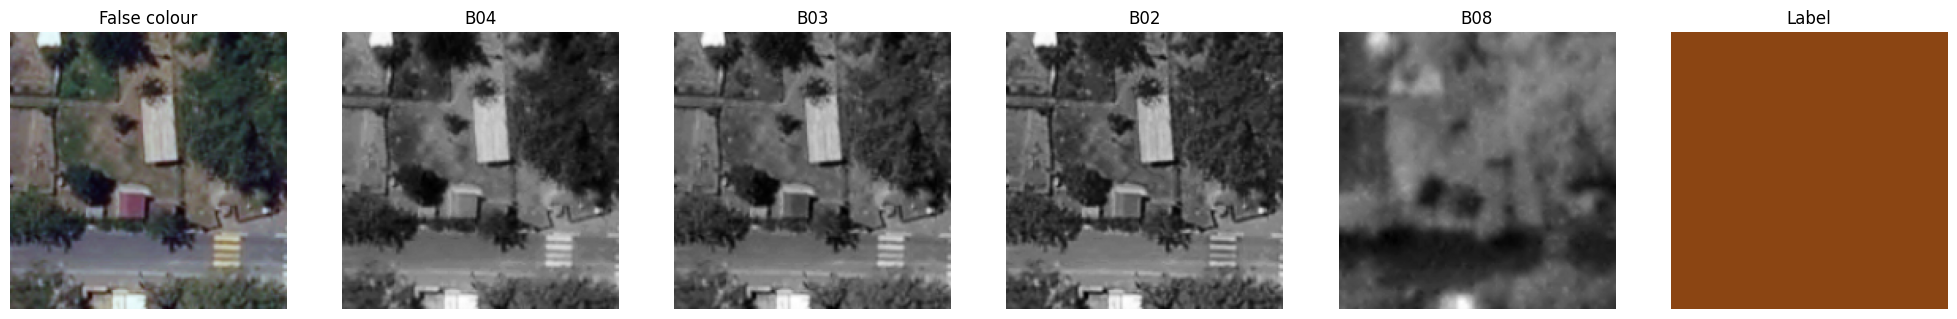

In [66]:
plot_batch(train_batch, labels=["False colour"] + band_labels)

In [67]:
train_batch[0][0][0].mean()

TensorImage(-0.2192, device='cuda:0')

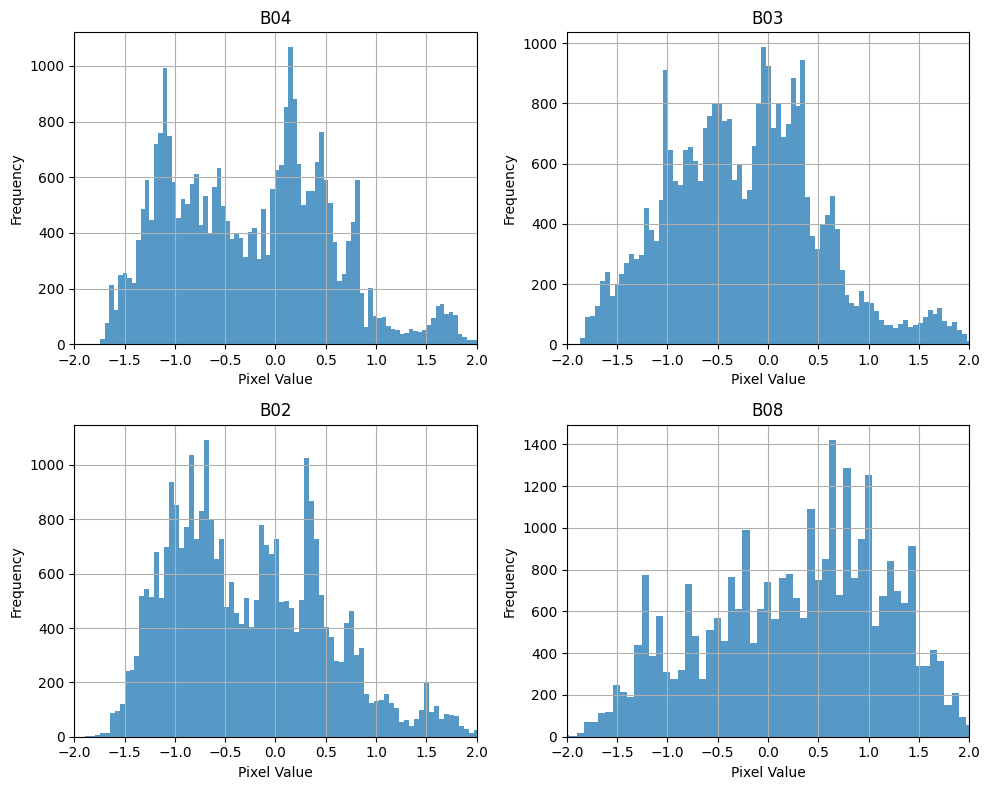

In [68]:
show_histo(train_batch, labels=band_labels)

In [69]:
train_batch[0].shape[1]

4

In [70]:
fai_model_name = f"PM_model_{model_full_name}_fai"
pytorch_model_name = f"PM_model_{model_full_name}_PT.pth"
pytorch_model_path = Path.cwd() / "models" / pytorch_model_name
state_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.pth"
safetensor_state_path = (
    pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.safetensors"
)
config_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_config.json"
if pytorch_model_path.exists():
    raise ValueError("Model already exists", pytorch_model_name)
if state_path.exists():
    raise ValueError("State path already exists")
if safetensor_state_path.exists():
    raise ValueError("Safetensor state path already exists")
if config_path.exists():
    raise ValueError("Config path already exists")

print(f"Fastai model {fai_model_name}")
print(f"PyTorch model {pytorch_model_name}")
print(f"State path: {state_path}")
print(f"Safetensor state path: {safetensor_state_path}")


Fastai model PM_model_2.0.7_S1S2_L2A_flair_only_water_edgenext_x_small_fai
PyTorch model PM_model_2.0.7_S1S2_L2A_flair_only_water_edgenext_x_small_PT.pth
State path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.7_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.pth
Safetensor state path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.7_S1S2_L2A_flair_only_water_edgenext_x_small_PT_state.safetensors


In [71]:
if pytorch_model_path.exists():
    raise ValueError("Model already exists")

In [72]:
class_loss_weights_tensor = torch.tensor(class_loss_weights).float().cuda()
class_loss_weights_tensor

tensor([1., 2.], device='cuda:0')

In [73]:
ignore_index = 99
cel = CrossEntropyLoss(
    reduction="none",
    weight=class_loss_weights_tensor,
    ignore_index=ignore_index,
)


def combo_loss(pred, target):
    # apply distance transform and set valid mask
    pixel_weight = distance_transform_torch(target, clip_distance=3)
    pixel_cel = cel(pred, target)
    return (pixel_cel * pixel_weight).mean()


In [74]:
metrics = [
    IgnoreIndexMetric(JaccardCoeff(axis=1), ignore_index=99),
]


In [75]:
callbacks = [
    SaveModelCallback(monitor="jaccard_coeff", fname=fai_model_name, with_opt=True),
    ShowGraphCallback(),
    GradientAccumulation(GA_batch_size),
]

In [76]:
if model_provider == "fastai":
    print(f"Using fastai model: {model_type}")
    timm_model = partial(
        timm.create_model,
        model_type,
        pretrained=True,
        in_chans=num_input_channels,
    )
    model = create_unet_model(
        img_size=(original_image_size, original_image_size),
        arch=timm_model,
        n_out=class_count,
        pretrained=True,
        act_cls=torch.nn.Mish,
    )
elif model_provider == "smp":
    print(f"Using segmentation_models_pytorch model: {model_type}")
    model = smp.Unet(
        encoder_name=f"tu-{model_type.split('.')[0]}",
        encoder_weights="imagenet",
        in_channels=num_input_channels,
        classes=class_count,
    )

else:
    raise ValueError(f"Unknown model provider: {model_provider}")


Using fastai model: edgenext_x_small.in1k


In [77]:
dummy_input = torch.randn(
    1, num_input_channels, original_image_size, original_image_size
)
model_output = model(dummy_input)
assert model_output.shape == (
    1,
    class_count,
    original_image_size,
    original_image_size,
), "Model output shape mismatch"


In [78]:
learner = Learner(
    dls=dl,
    model=model,
    loss_func=combo_loss,
    metrics=metrics,
    cbs=callbacks,
)


In [79]:
if bf16:
    print("Using BF16")
    learner = learner.to_bf16()

print(f"Using learning rate: {learning_rate}, with model {model_type}")

Using BF16
Using learning rate: 0.0001, with model edgenext_x_small.in1k


epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.455441,0.409404,0.465009,05:18


Better model found at epoch 0 with jaccard_coeff value: 0.46500862704487916.


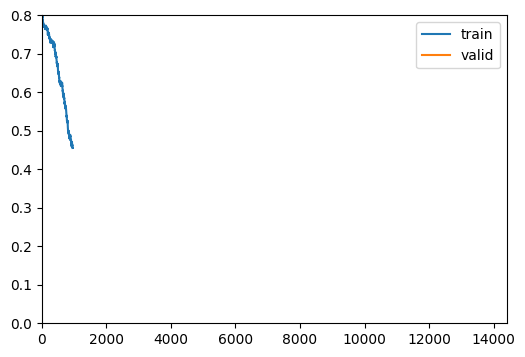

In [ ]:
learner.fit_one_cycle(
    n_epoch=epoch_count,
    lr_max=learning_rate,
)

In [ ]:
# reload the model to get the best one
learner.load(fai_model_name)

In [ ]:
# extract model from learner and move to cpu
model = learner.model.to("cpu")
model = model.float()

In [ ]:
torch.save(model, pytorch_model_path)
pytorch_model_path

In [ ]:
torch.save(model.state_dict(), state_path)
state_path

In [ ]:
save_file(model.state_dict(), safetensor_state_path)
safetensor_state_path